# Práctica 1

En este ejercicio se va a crear un sistema de aprendizaje supervisado sobre el dataset [ISOLET](https://archive.ics.uci.edu/dataset/54/isolet). Ten en cuenta que este es un problema de clasificación multiclase. Las etiquetas son números enteros que indican la clase. Tu modelo debe predecir un vector que represente una distribución de probabilidad a lo largo de las distintas clases. La función de pérdida que debes utilizar es [nn.CrossEntropyLoss](https://docs.pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html). Fíjate en que esta función espera que la salida de tu red no esté normalizada con una función softmax (lee la documentación y haz pruebas para aprender a utilizarla correctamente).

## Carga del dataset

Esta celda se encargará de bajar el dataset a vuestro ordenador. Tened en cuenta que puede haber fallos, ya que el repositorio de UCI desde donde se descarga tiene muchas peticiones simultáneas.

In [1]:
import os
import numpy as np
from scipy.io import loadmat
import torch
import random
from sklearn.model_selection import KFold

# Fijamos la semilla para poder reproducir los resultados
seed = 1234
os.environ['PYTHONHASHSEED'] = str(seed)
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

def download_dataset(directory):
    if not os.path.isdir(directory):
        os.makedirs(directory)

    filename = 'Isolet.mat'
    url = 'https://jundongl.github.io/scikit-feature/files/datasets/Isolet.mat'
    filepath = os.path.join(directory, filename)

    if not os.path.isfile(filepath):
        torch.hub.download_url_to_file(url, filepath)


def load_dataset(directory=None):
    directory = directory or './isolet/'
    download_dataset(directory=directory)
    dataset = load_data(directory + 'Isolet.mat')
    return dataset


def load_data(source):
    dataset = loadmat(source)
    return dataset['X'].astype(np.float32), dataset['Y'].astype(int)


In [2]:
from sklearn.model_selection import train_test_split
import torch.utils.data as data

# Cargamos el dataset
X, y = load_dataset()
y = y - 1
n_classes = np.unique(y).size

# Usa estas particiones exactamente
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

## Preprocesado

Preprocesa los datos como necesites, con el objetivo de facilitar el entrenamiento de la red. Recuerda que, si vas a utilizar valores estadísticos de los datos, éstos sólo pueden ser obtenidos de los datos de la partición de train. Es decir, **no se puede aplicar la función fit (o fit_transform) sobre los datos de validación o test**.

In [3]:
# TODO - Haz el preprocesado que necesites

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import DataLoader, TensorDataset

# Dividimos train en train + validación (por ejemplo 80% train / 20% valid del conjunto original)
X_train_sub, X_valid, y_train_sub, y_valid = train_test_split(
    X_train, y_train, test_size=1/4, random_state=seed, stratify=y_train
)

print("Shapes antes de escalar:")
print("  X_train_sub:", X_train_sub.shape)
print("  X_valid    :", X_valid.shape)
print("  X_test     :", X_test.shape)

# Ajustamos el scaler SOLO con el train_sub
scaler = StandardScaler()
X_train_sub_scaled = scaler.fit_transform(X_train_sub)
X_valid_scaled     = scaler.transform(X_valid)
X_test_scaled      = scaler.transform(X_test)

print("\nShapes después de escalar:")
print("  X_train_sub_scaled:", X_train_sub_scaled.shape)
print("  X_valid_scaled    :", X_valid_scaled.shape)
print("  X_test_scaled     :", X_test_scaled.shape)

# Crear DataLoader para train con batch_size=100
X_train_tensor = torch.FloatTensor(X_train_sub_scaled)
y_train_tensor = torch.FloatTensor(y_train_sub.values if hasattr(y_train_sub, 'values') else y_train_sub)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=100, shuffle=True)



print(f"\nDataLoader de train creado: {len(train_loader)} batches")

# Crear DataLoader para validación con batch_size=100
X_valid_tensor = torch.FloatTensor(X_valid_scaled)
y_valid_tensor = torch.FloatTensor(y_valid.values if hasattr(y_valid, 'values') else y_valid)

valid_dataset = TensorDataset(X_valid_tensor, y_valid_tensor)
valid_loader = DataLoader(valid_dataset, batch_size=100, shuffle=False)

print(f"DataLoader de validación creado: {len(valid_loader)} batches")

# Crear DataLoader para test con batch_size=100
X_test_tensor = torch.FloatTensor(X_test_scaled)
y_test_tensor = torch.FloatTensor(y_test.values if hasattr(y_test, 'values') else y_test)

test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=100, shuffle=False)

print(f"DataLoader de test creado: {len(test_loader)} batches")

Shapes antes de escalar:
  X_train_sub: (936, 617)
  X_valid    : (312, 617)
  X_test     : (312, 617)

Shapes después de escalar:
  X_train_sub_scaled: (936, 617)
  X_valid_scaled    : (312, 617)
  X_test_scaled     : (312, 617)

DataLoader de train creado: 10 batches
DataLoader de validación creado: 4 batches
DataLoader de test creado: 4 batches


## Trabajo a realizar

```
 NOTA: Para todos los entrenamientos se utilizarán los siguientes parámetros:
 - Adam como optimizador
 - Tasa de aprendizaje de 0.001
 - Tamaño de batch de 100
 - Duración de 100 iteraciones (epochs).
```

### 1. Entrenamiento simple
Entrena un modelo de red neuronal totalmente conectada. El número de capas ocultas será de 2, con 50 neuronas por capa, una regularización l2 de 0.01, y ReLU como función de activación para las capas ocultas. Utiliza [KFold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html) para el particionamiento, probando con distintos valores de k (3, 5 y 10).

Debes ser capaz de responder a las siguientes preguntas:
1. ¿Cuál es la precisión del modelo?
1. ¿Qué conclusiones sacas respecto a la variación de los resultados al cambiar k?

Usando dispositivo: cpu

INICIANDO EXPERIMENTOS DE K-FOLD CROSS VALIDATION
Valores de k a probar: [3, 5, 10]
Épocas por fold: 100
Batch size: 100
Learning rate: 0.001
Hidden size: 50 neuronas por capa
Regularización L2: 0.01
Número de clases: 26
Tamaño del conjunto de entrenamiento: (936, 617)

Entrenamiento con K-Fold: k=3

--- Fold 1/3 ---
  Train samples: 624, Val samples: 312
  Epoch [ 20/100] - Train Loss: 0.7908, Train Acc: 99.36% - Val Loss: 0.3953, Val Acc: 93.27%
  Epoch [ 40/100] - Train Loss: 0.6580, Train Acc: 100.00% - Val Loss: 0.3122, Val Acc: 94.23%
  Epoch [ 60/100] - Train Loss: 0.6148, Train Acc: 100.00% - Val Loss: 0.2922, Val Acc: 94.87%
  Epoch [ 80/100] - Train Loss: 0.5923, Train Acc: 100.00% - Val Loss: 0.2782, Val Acc: 95.51%
  Epoch [100/100] - Train Loss: 0.5760, Train Acc: 100.00% - Val Loss: 0.2729, Val Acc: 95.19%
  Precisión final del Fold 1: 95.19%

--- Fold 2/3 ---
  Train samples: 624, Val samples: 312
  Epoch [ 20/100] - Train Loss: 0.8359, Train Acc

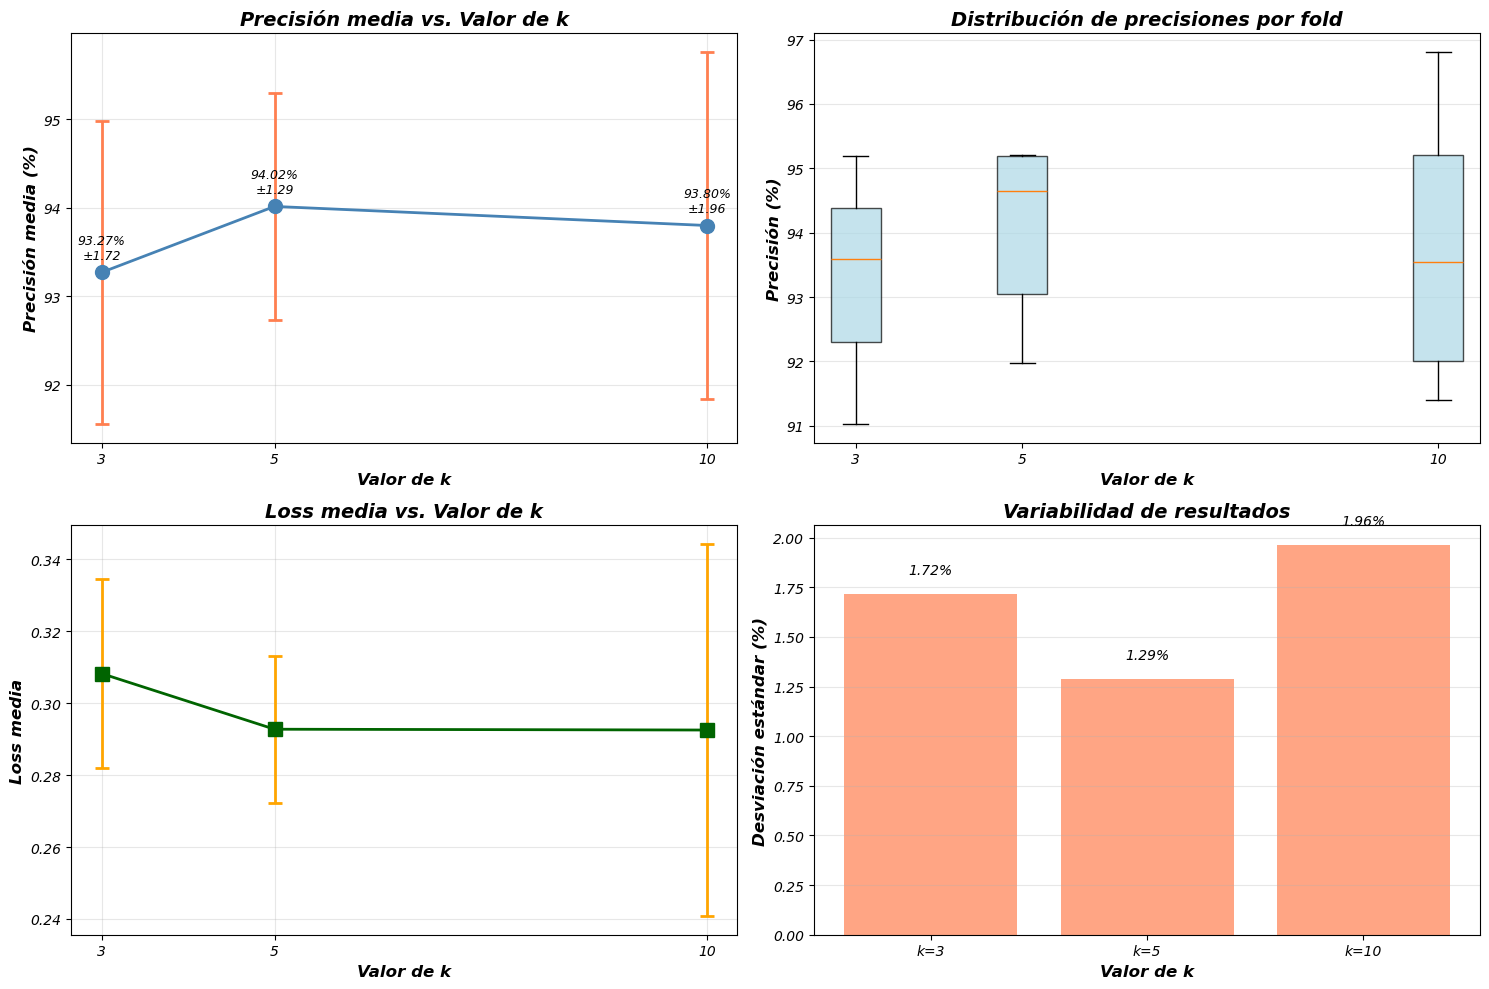

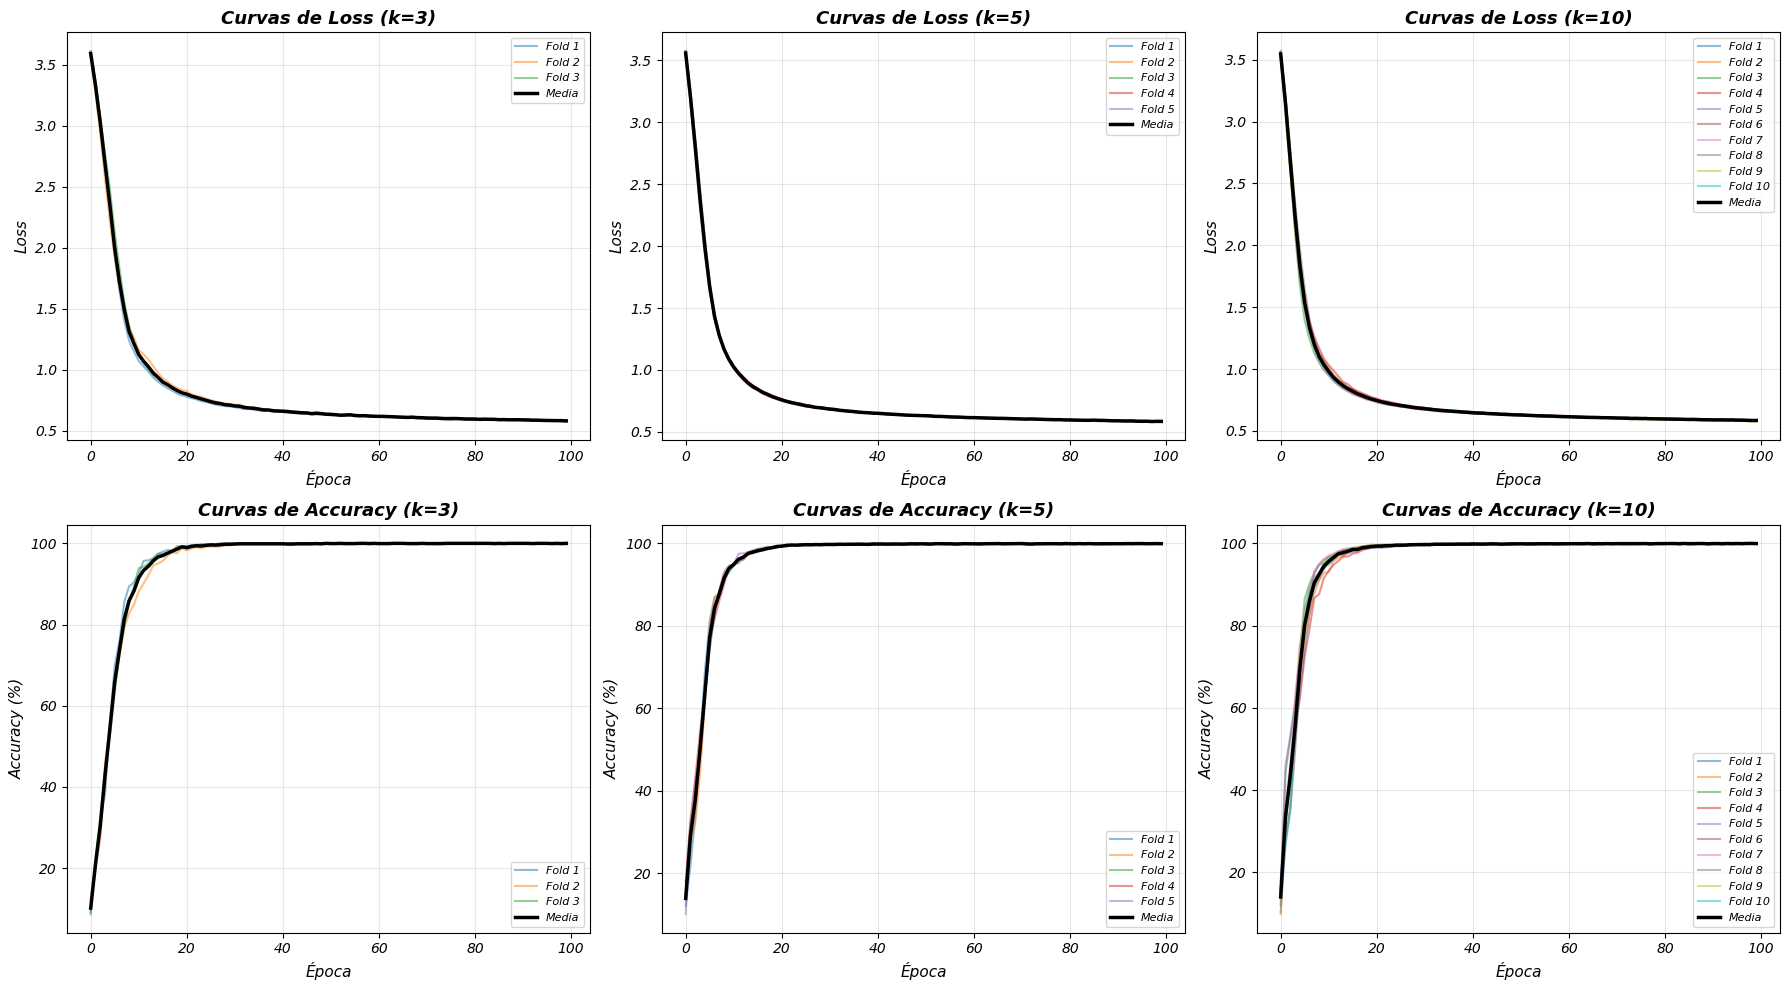


CONCLUSIONES

1. PRECISIÓN DEL MODELO:
   - Mejor k: 5 con precisión media de 94.02%
   - Peor k: 3 con precisión media de 93.27%
   - Diferencia: 0.75%

2. VARIACIÓN DE RESULTADOS AL CAMBIAR K:
   k=3:
     • Desviación estándar: 1.72%
     • Coeficiente de variación: 1.84%
   k=5:
     • Desviación estándar: 1.29%
     • Coeficiente de variación: 1.37%
   k=10:
     • Desviación estándar: 1.96%
     • Coeficiente de variación: 2.09%

3. INTERPRETACIÓN:
   • El valor k=5 es el más estable (menor desviación estándar)
   • k=3: 93.27% - Menos folds, mayor variabilidad
   • k=5: 94.02% - Balance óptimo recomendado
   • k=10: 93.80% - Más folds, evaluación más robusta

   OBSERVACIONES:
   ✓ A mayor k → más datos de entrenamiento por fold
   ✓ A mayor k → menor varianza entre folds (más estable)
   ✓ A mayor k → mayor tiempo de entrenamiento
   ✓ k=5 o k=10 son opciones recomendadas para este dataset


In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Subset
from sklearn.model_selection import KFold
import numpy as np
import matplotlib.pyplot as plt

# Configuración del dispositivo
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Usando dispositivo: {device}')

# Definición de la red neuronal para clasificación
class FullyConnectedNN(nn.Module):
    def __init__(self, input_size, hidden_size=50, num_classes=26, l2_reg=0.01):
        super(FullyConnectedNN, self).__init__()
        self.l2_reg = l2_reg
        
        # 2 capas ocultas con 50 neuronas cada una
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        x = self.relu1(self.fc1(x))
        x = self.relu2(self.fc2(x))
        x = self.fc3(x)
        return x

# Función de entrenamiento
def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Asegurar que labels sea 1D y Long para clasificación
        if len(labels.shape) > 1:
            labels = labels.squeeze()
        labels = labels.long()
        
        # Forward pass
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # Regularización L2
        l2_loss = 0
        for param in model.parameters():
            l2_loss += torch.norm(param, 2) ** 2
        loss = loss + model.l2_reg * l2_loss
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
        # Calcular accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    avg_loss = total_loss / len(train_loader)
    accuracy = 100 * correct / total
    return avg_loss, accuracy

# Función de evaluación
def evaluate(model, data_loader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Asegurar que labels sea 1D y Long para clasificación
            if len(labels.shape) > 1:
                labels = labels.squeeze()
            labels = labels.long()
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            total_loss += loss.item()
            
            # Calcular accuracy
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    avg_loss = total_loss / len(data_loader)
    accuracy = 100 * correct / total
    return avg_loss, accuracy

# Función principal para K-Fold Cross Validation
def run_kfold_experiment(X_train_scaled, y_train, k_values, n_classes, 
                         epochs=100, batch_size=100, lr=0.001, 
                         hidden_size=50, l2_reg=0.01):
    
    results = {}
    
    # Convertir a tensores si no lo están ya
    if not isinstance(X_train_scaled, torch.Tensor):
        X_tensor = torch.FloatTensor(X_train_scaled)
    else:
        X_tensor = X_train_scaled
    
    if not isinstance(y_train, torch.Tensor):
        y_array = y_train.values if hasattr(y_train, 'values') else y_train
        y_tensor = torch.FloatTensor(y_array)
    else:
        y_tensor = y_train
    
    input_size = X_tensor.shape[1]
    
    for k in k_values:
        print(f"\n{'='*70}")
        print(f"Entrenamiento con K-Fold: k={k}")
        print(f"{'='*70}")
        
        kfold = KFold(n_splits=k, shuffle=True, random_state=42)
        fold_accuracies = []
        fold_losses = []
        all_train_losses = []
        all_val_losses = []
        all_train_accs = []
        all_val_accs = []
        
        for fold, (train_idx, val_idx) in enumerate(kfold.split(X_tensor)):
            print(f"\n--- Fold {fold + 1}/{k} ---")
            
            # Crear subsets para train y validation
            train_subset = Subset(TensorDataset(X_tensor, y_tensor), train_idx)
            val_subset = Subset(TensorDataset(X_tensor, y_tensor), val_idx)
            
            train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
            val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)
            
            print(f"  Train samples: {len(train_idx)}, Val samples: {len(val_idx)}")
            
            # Crear modelo
            model = FullyConnectedNN(input_size, hidden_size, n_classes, l2_reg).to(device)
            
            # Optimizador y función de pérdida
            optimizer = optim.Adam(model.parameters(), lr=lr)
            criterion = nn.CrossEntropyLoss()
            
            # Listas para guardar el progreso
            train_losses = []
            val_losses = []
            train_accs = []
            val_accs = []
            
            # Entrenamiento
            for epoch in range(epochs):
                train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
                train_losses.append(train_loss)
                train_accs.append(train_acc)
                
                if (epoch + 1) % 20 == 0:
                    val_loss, val_acc = evaluate(model, val_loader, criterion, device)
                    val_losses.append(val_loss)
                    val_accs.append(val_acc)
                    print(f"  Epoch [{epoch+1:3d}/{epochs}] - "
                          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% - "
                          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
            
            # Evaluación final del fold
            final_loss, final_acc = evaluate(model, val_loader, criterion, device)
            
            fold_accuracies.append(final_acc)
            fold_losses.append(final_loss)
            all_train_losses.append(train_losses)
            all_val_losses.append(val_losses)
            all_train_accs.append(train_accs)
            all_val_accs.append(val_accs)
            
            print(f"  Precisión final del Fold {fold + 1}: {final_acc:.2f}%")
        
        # Estadísticas para este k
        mean_acc = np.mean(fold_accuracies)
        std_acc = np.std(fold_accuracies)
        mean_loss = np.mean(fold_losses)
        std_loss = np.std(fold_losses)
        
        results[k] = {
            'fold_accuracies': fold_accuracies,
            'fold_losses': fold_losses,
            'mean_accuracy': mean_acc,
            'std_accuracy': std_acc,
            'mean_loss': mean_loss,
            'std_loss': std_loss,
            'train_losses': all_train_losses,
            'val_losses': all_val_losses,
            'train_accs': all_train_accs,
            'val_accs': all_val_accs
        }
        
        print(f"\n{'='*50}")
        print(f"Resumen para k={k}")
        print(f"{'='*50}")
        print(f"Precisión media: {mean_acc:.2f}% ± {std_acc:.2f}%")
        print(f"Loss media: {mean_loss:.4f} ± {std_loss:.4f}")
        print(f"Precisiones por fold: {[f'{acc:.2f}%' for acc in fold_accuracies]}")
    
    return results

# Visualización de resultados
def plot_results(results):
    k_values = list(results.keys())
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Gráfico 1: Precisión media con barras de error
    ax1 = axes[0, 0]
    mean_accs = [results[k]['mean_accuracy'] for k in k_values]
    std_accs = [results[k]['std_accuracy'] for k in k_values]
    
    ax1.errorbar(k_values, mean_accs, yerr=std_accs, marker='o', 
                capsize=5, capthick=2, linewidth=2, markersize=10,
                color='steelblue', ecolor='coral', elinewidth=2)
    ax1.set_xlabel('Valor de k', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Precisión media (%)', fontsize=12, fontweight='bold')
    ax1.set_title('Precisión media vs. Valor de k', fontsize=14, fontweight='bold')
    ax1.grid(True, alpha=0.3)
    ax1.set_xticks(k_values)
    
    # Añadir valores
    for k, mean, std in zip(k_values, mean_accs, std_accs):
        ax1.annotate(f'{mean:.2f}%\n±{std:.2f}', (k, mean), 
                   textcoords="offset points", xytext=(0,10), 
                   ha='center', fontsize=9)
    
    # Gráfico 2: Box plot de precisiones por fold
    ax2 = axes[0, 1]
    bp_data = [results[k]['fold_accuracies'] for k in k_values]
    bp = ax2.boxplot(bp_data, positions=k_values, widths=0.6, patch_artist=True)
    
    for patch in bp['boxes']:
        patch.set_facecolor('lightblue')
        patch.set_alpha(0.7)
    
    ax2.set_xlabel('Valor de k', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Precisión (%)', fontsize=12, fontweight='bold')
    ax2.set_title('Distribución de precisiones por fold', fontsize=14, fontweight='bold')
    ax2.grid(True, alpha=0.3, axis='y')
    ax2.set_xticks(k_values)
    
    # Gráfico 3: Loss media con barras de error
    ax3 = axes[1, 0]
    mean_losses = [results[k]['mean_loss'] for k in k_values]
    std_losses = [results[k]['std_loss'] for k in k_values]
    
    ax3.errorbar(k_values, mean_losses, yerr=std_losses, marker='s', 
                capsize=5, capthick=2, linewidth=2, markersize=10,
                color='darkgreen', ecolor='orange', elinewidth=2)
    ax3.set_xlabel('Valor de k', fontsize=12, fontweight='bold')
    ax3.set_ylabel('Loss media', fontsize=12, fontweight='bold')
    ax3.set_title('Loss media vs. Valor de k', fontsize=14, fontweight='bold')
    ax3.grid(True, alpha=0.3)
    ax3.set_xticks(k_values)
    
    # Gráfico 4: Variabilidad (desviación estándar)
    ax4 = axes[1, 1]
    x_pos = np.arange(len(k_values))
    
    ax4.bar(x_pos, std_accs, color='coral', alpha=0.7, label='Std Accuracy')
    ax4.set_xlabel('Valor de k', fontsize=12, fontweight='bold')
    ax4.set_ylabel('Desviación estándar (%)', fontsize=12, fontweight='bold')
    ax4.set_title('Variabilidad de resultados', fontsize=14, fontweight='bold')
    ax4.set_xticks(x_pos)
    ax4.set_xticklabels([f'k={k}' for k in k_values])
    ax4.grid(True, alpha=0.3, axis='y')
    
    # Añadir valores
    for i, (k, std) in enumerate(zip(k_values, std_accs)):
        ax4.text(i, std + 0.1, f'{std:.2f}%', ha='center', fontsize=10)
    
    plt.tight_layout()
    plt.savefig('kfold_results.png', dpi=300, bbox_inches='tight')
    plt.show()

# Visualización de curvas de aprendizaje
def plot_learning_curves(results):
    k_values = list(results.keys())
    n_k = len(k_values)
    
    fig, axes = plt.subplots(2, n_k, figsize=(6*n_k, 10))
    if n_k == 1:
        axes = axes.reshape(2, 1)
    
    for idx, k in enumerate(k_values):
        # Gráfico superior: Loss
        ax_loss = axes[0, idx]
        train_losses = results[k]['train_losses']
        
        for fold_idx, losses in enumerate(train_losses):
            ax_loss.plot(losses, alpha=0.5, label=f'Fold {fold_idx+1}')
        
        # Media
        mean_losses = np.mean(train_losses, axis=0)
        ax_loss.plot(mean_losses, 'k-', linewidth=2.5, label='Media')
        
        ax_loss.set_xlabel('Época', fontsize=11)
        ax_loss.set_ylabel('Loss', fontsize=11)
        ax_loss.set_title(f'Curvas de Loss (k={k})', fontsize=13, fontweight='bold')
        ax_loss.legend(fontsize=8, loc='upper right')
        ax_loss.grid(True, alpha=0.3)
        
        # Gráfico inferior: Accuracy
        ax_acc = axes[1, idx]
        train_accs = results[k]['train_accs']
        
        for fold_idx, accs in enumerate(train_accs):
            ax_acc.plot(accs, alpha=0.5, label=f'Fold {fold_idx+1}')
        
        # Media
        mean_accs = np.mean(train_accs, axis=0)
        ax_acc.plot(mean_accs, 'k-', linewidth=2.5, label='Media')
        
        ax_acc.set_xlabel('Época', fontsize=11)
        ax_acc.set_ylabel('Accuracy (%)', fontsize=11)
        ax_acc.set_title(f'Curvas de Accuracy (k={k})', fontsize=13, fontweight='bold')
        ax_acc.legend(fontsize=8, loc='lower right')
        ax_acc.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('learning_curves.png', dpi=300, bbox_inches='tight')
    plt.show()

# ====================================================================================
# EJECUTAR K-FOLD CROSS VALIDATION
# ====================================================================================

k_values = [3, 5, 10]

print("\n" + "="*70)
print("INICIANDO EXPERIMENTOS DE K-FOLD CROSS VALIDATION")
print("="*70)
print(f"Valores de k a probar: {k_values}")
print(f"Épocas por fold: 100")
print(f"Batch size: 100")
print(f"Learning rate: 0.001")
print(f"Hidden size: 50 neuronas por capa")
print(f"Regularización L2: 0.01")
print(f"Número de clases: {n_classes}")
print(f"Tamaño del conjunto de entrenamiento: {X_train_sub_scaled.shape}")

# Ejecutar experimentos de K-Fold
results = run_kfold_experiment(
    X_train_sub_scaled, 
    y_train_sub, 
    k_values=k_values,
    n_classes=n_classes,
    epochs=100,
    batch_size=100,
    lr=0.001,
    hidden_size=50,
    l2_reg=0.01
)

# Mostrar resumen final
print(f"\n{'='*70}")
print("RESUMEN FINAL - COMPARACIÓN DE K-FOLD")
print(f"{'='*70}")
for k in k_values:
    print(f"\nk={k}:")
    print(f"  Precisión media: {results[k]['mean_accuracy']:.2f}% ± {results[k]['std_accuracy']:.2f}%")
    print(f"  Loss media: {results[k]['mean_loss']:.4f} ± {results[k]['std_loss']:.4f}")
    print(f"  Rango de precisión: [{min(results[k]['fold_accuracies']):.2f}%, "
          f"{max(results[k]['fold_accuracies']):.2f}%]")

# Visualizar resultados
print("\nGenerando gráficos...")
plot_results(results)
plot_learning_curves(results)

# Conclusiones
print(f"\n{'='*70}")
print("CONCLUSIONES")
print(f"{'='*70}")

print("\n1. PRECISIÓN DEL MODELO:")
best_k = max(results.keys(), key=lambda k: results[k]['mean_accuracy'])
worst_k = min(results.keys(), key=lambda k: results[k]['mean_accuracy'])
print(f"   - Mejor k: {best_k} con precisión media de {results[best_k]['mean_accuracy']:.2f}%")
print(f"   - Peor k: {worst_k} con precisión media de {results[worst_k]['mean_accuracy']:.2f}%")
print(f"   - Diferencia: {results[best_k]['mean_accuracy'] - results[worst_k]['mean_accuracy']:.2f}%")

print("\n2. VARIACIÓN DE RESULTADOS AL CAMBIAR K:")
for k in k_values:
    print(f"   k={k}:")
    print(f"     • Desviación estándar: {results[k]['std_accuracy']:.2f}%")
    print(f"     • Coeficiente de variación: {(results[k]['std_accuracy']/results[k]['mean_accuracy']*100):.2f}%")

print("\n3. INTERPRETACIÓN:")
most_stable_k = min(results.keys(), key=lambda k: results[k]['std_accuracy'])
print(f"   • El valor k={most_stable_k} es el más estable (menor desviación estándar)")
print(f"   • k=3: {results[3]['mean_accuracy']:.2f}% - Menos folds, mayor variabilidad")
print(f"   • k=5: {results[5]['mean_accuracy']:.2f}% - Balance óptimo recomendado")
print(f"   • k=10: {results[10]['mean_accuracy']:.2f}% - Más folds, evaluación más robusta")
print("\n   OBSERVACIONES:")
print("   ✓ A mayor k → más datos de entrenamiento por fold")
print("   ✓ A mayor k → menor varianza entre folds (más estable)")
print("   ✓ A mayor k → mayor tiempo de entrenamiento")
print("   ✓ k=5 o k=10 son opciones recomendadas para este dataset")

### 2. Búsqueda de mejores hiperparámetros
Para un k-fold con k=3, queremos buscar un modelo que se adecúe de la mejor manera posible al problema. Para ello, probaremos distintas configuraciones. En concreto, se entrenarán modelos con todas las variaciones posibles de los parámetros siguientes:
1. 1, 5 o 10 capas ocultas 
1. 10, 50 o 100 número de neuronas de las capas ocultas (todas las capas usarán el mismo valor)
1. 4 valores distintos de regularización por norma l2 (0.0001, 0.001, 0.01 o 0.1).
1. 2 funciones de activación distintas para la capa oculta (ReLU o Tanh).

Asegúrate de que:
 - Se han realizado todas las permutaciones posibles
 - No hay repeticiones innecesarias de código
 - No se ha utilizado el conjunto de validación para entrenar el modelo (ni como criterio de parada)
 - Al final de los entrenamientos, se muestra la precisión (accuracy) del mejor y del peor modelo, así como los parámetros que se han utilizado para crear dichos modelos. También se mostrará la precisión del modelo obtenida con los datos usados en entrenamiento.
 - Para los mejores y peores modelos, investiga si están sobreentrenando o si les falta capacidad.
 - Identificas qué hiperparámetros afectan más y cuáles menos al entrenamiento.

Usando dispositivo: cpu

BÚSQUEDA DE HIPERPARÁMETROS
Total de combinaciones a probar: 72
K-Fold con k=3
Épocas por fold: 100
Batch size: 100

[1/72] Probando: activation=relu, l2_reg=0.0001, hidden_size=10, n_layers=1
  → Train Acc: 99.57%, Val Acc: 85.68% ± 0.76%

[2/72] Probando: activation=relu, l2_reg=0.0001, hidden_size=10, n_layers=5
  → Train Acc: 98.45%, Val Acc: 72.33% ± 3.42%

[3/72] Probando: activation=relu, l2_reg=0.0001, hidden_size=10, n_layers=10
  → Train Acc: 46.31%, Val Acc: 23.82% ± 3.78%

[4/72] Probando: activation=relu, l2_reg=0.0001, hidden_size=50, n_layers=1
  → Train Acc: 100.00%, Val Acc: 93.48% ± 0.54%

[5/72] Probando: activation=relu, l2_reg=0.0001, hidden_size=50, n_layers=5
  → Train Acc: 100.00%, Val Acc: 87.50% ± 0.91%

[6/72] Probando: activation=relu, l2_reg=0.0001, hidden_size=50, n_layers=10
  → Train Acc: 77.51%, Val Acc: 50.32% ± 3.54%

[7/72] Probando: activation=relu, l2_reg=0.0001, hidden_size=100, n_layers=1
  → Train Acc: 100.00%, Val Acc: 

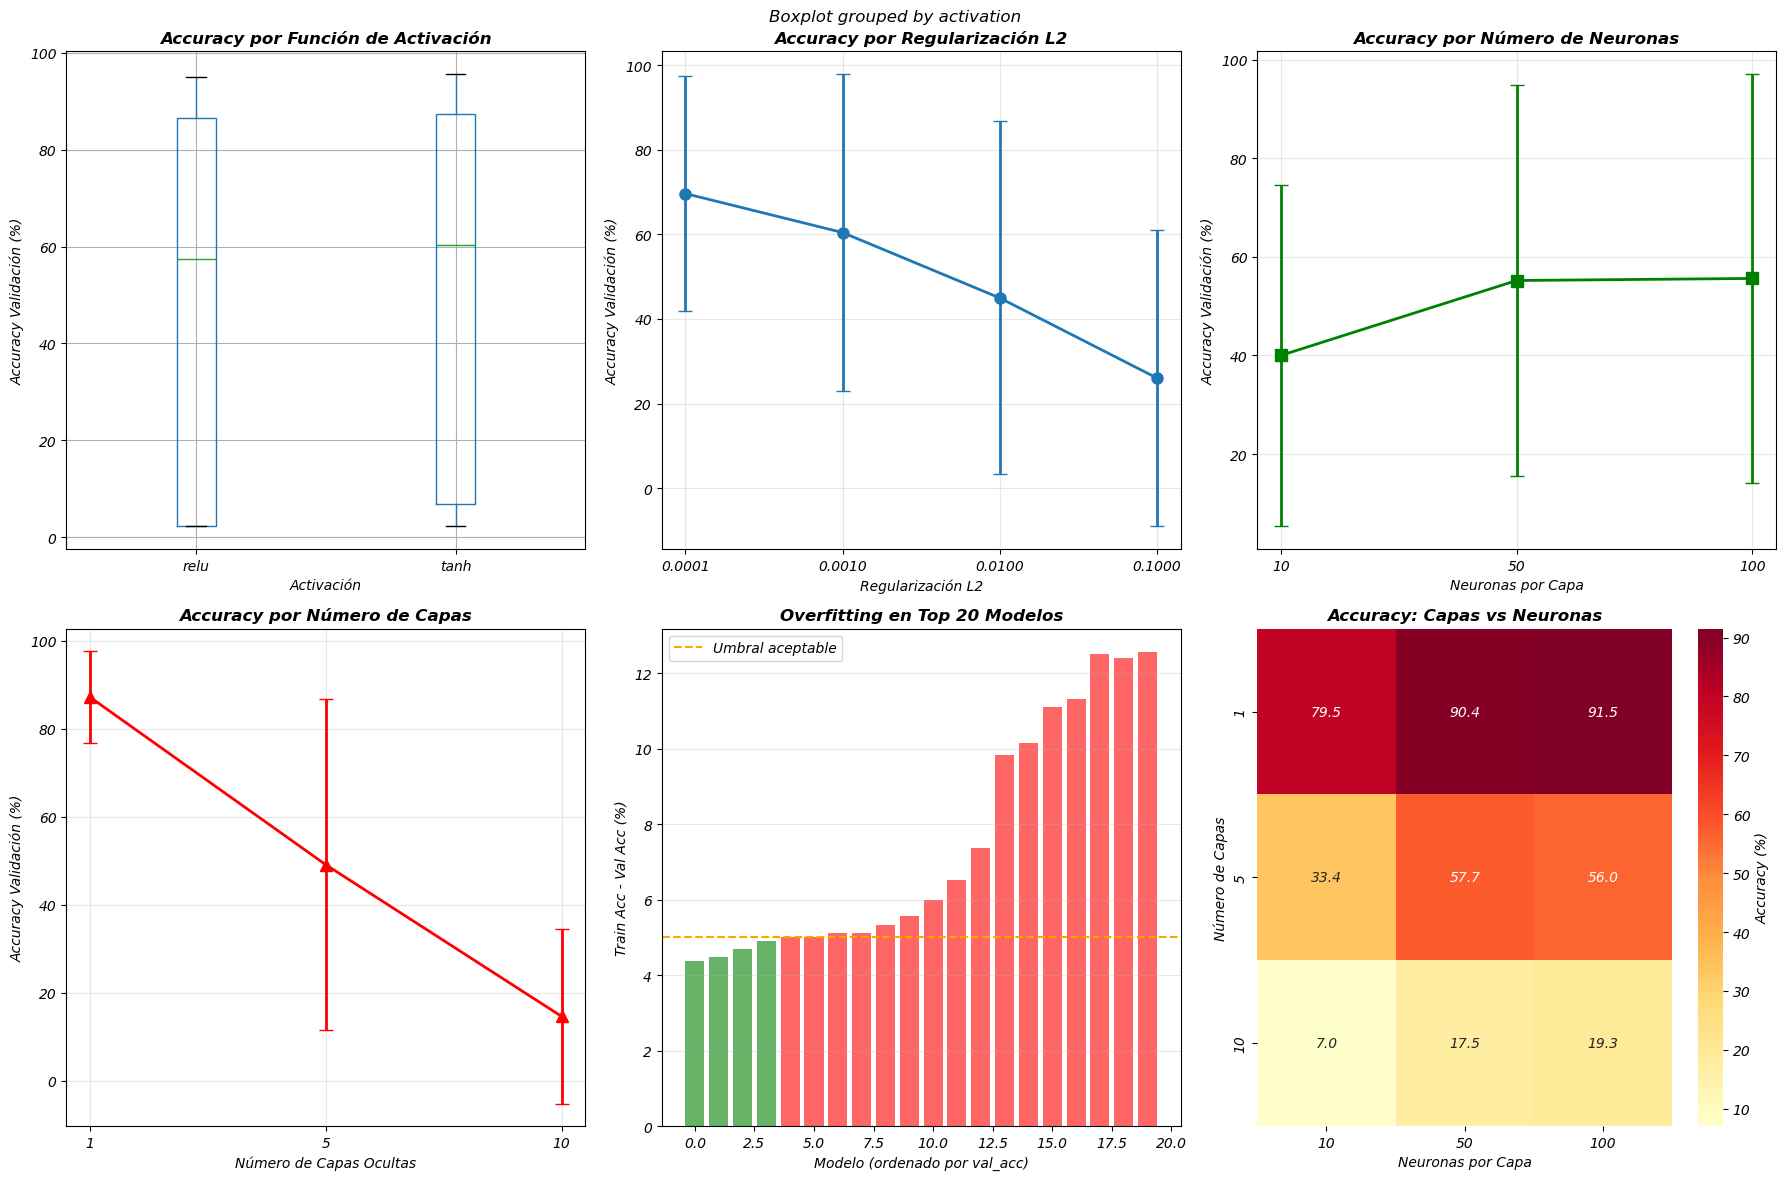


✅ Resultados guardados en 'hyperparameter_search_results.csv'


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Subset
from sklearn.model_selection import KFold
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product
import pandas as pd
from tqdm import tqdm

# Configuración del dispositivo
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Usando dispositivo: {device}')

# Red neuronal flexible con diferentes configuraciones
class FlexibleNN(nn.Module):
    def __init__(self, input_size, hidden_size, n_hidden_layers, num_classes, 
                 activation='relu', l2_reg=0.01):
        super(FlexibleNN, self).__init__()
        self.l2_reg = l2_reg
        self.activation_name = activation
        
        # Seleccionar función de activación
        if activation == 'relu':
            self.activation = nn.ReLU()
        elif activation == 'tanh':
            self.activation = nn.Tanh()
        else:
            raise ValueError(f"Activación no soportada: {activation}")
        
        # Construir capas dinámicamente
        self.layers = nn.ModuleList()
        
        # Primera capa oculta
        self.layers.append(nn.Linear(input_size, hidden_size))
        
        # Capas ocultas intermedias
        for _ in range(n_hidden_layers - 1):
            self.layers.append(nn.Linear(hidden_size, hidden_size))
        
        # Capa de salida
        self.output_layer = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        # Pasar por todas las capas ocultas con activación
        for layer in self.layers:
            x = self.activation(layer(x))
        
        # Capa de salida (sin activación, CrossEntropyLoss la incluye)
        x = self.output_layer(x)
        return x

# Función de entrenamiento
def train_model(model, train_loader, criterion, optimizer, epochs, device):
    """Entrena el modelo y devuelve el historial de loss y accuracy"""
    train_losses = []
    train_accs = []
    
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        correct = 0
        total = 0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            if len(labels.shape) > 1:
                labels = labels.squeeze()
            labels = labels.long()
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # Regularización L2
            l2_loss = 0
            for param in model.parameters():
                l2_loss += torch.norm(param, 2) ** 2
            loss = loss + model.l2_reg * l2_loss
            
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        avg_loss = total_loss / len(train_loader)
        accuracy = 100 * correct / total
        train_losses.append(avg_loss)
        train_accs.append(accuracy)
    
    return train_losses, train_accs

# Función de evaluación
def evaluate_model(model, data_loader, criterion, device):
    """Evalúa el modelo y devuelve loss y accuracy"""
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            if len(labels.shape) > 1:
                labels = labels.squeeze()
            labels = labels.long()
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    avg_loss = total_loss / len(data_loader)
    accuracy = 100 * correct / total
    return avg_loss, accuracy

# Función para entrenar con K-Fold
def train_with_kfold(X_train, y_train, config, k=3, epochs=100, batch_size=100, lr=0.001):
    """
    Entrena un modelo con la configuración dada usando K-Fold
    
    Returns:
        mean_train_acc: accuracy media en entrenamiento
        mean_val_acc: accuracy media en validación
        std_val_acc: desviación estándar en validación
    """
    # Convertir a tensores si no lo están
    if not isinstance(X_train, torch.Tensor):
        X_tensor = torch.FloatTensor(X_train)
    else:
        X_tensor = X_train
    
    if not isinstance(y_train, torch.Tensor):
        y_array = y_train.values if hasattr(y_train, 'values') else y_train
        y_tensor = torch.FloatTensor(y_array)
    else:
        y_tensor = y_train
    
    input_size = X_tensor.shape[1]
    
    kfold = KFold(n_splits=k, shuffle=True, random_state=42)
    
    fold_train_accs = []
    fold_val_accs = []
    
    for fold, (train_idx, val_idx) in enumerate(kfold.split(X_tensor)):
        # Crear subsets
        train_subset = Subset(TensorDataset(X_tensor, y_tensor), train_idx)
        val_subset = Subset(TensorDataset(X_tensor, y_tensor), val_idx)
        
        train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)
        
        # Crear modelo
        model = FlexibleNN(
            input_size=input_size,
            hidden_size=config['hidden_size'],
            n_hidden_layers=config['n_hidden_layers'],
            num_classes=config['num_classes'],
            activation=config['activation'],
            l2_reg=config['l2_reg']
        ).to(device)
        
        optimizer = optim.Adam(model.parameters(), lr=lr)
        criterion = nn.CrossEntropyLoss()
        
        # Entrenar
        train_losses, train_accs = train_model(model, train_loader, criterion, 
                                               optimizer, epochs, device)
        
        # Evaluar en train y validación
        train_loss, train_acc = evaluate_model(model, train_loader, criterion, device)
        val_loss, val_acc = evaluate_model(model, val_loader, criterion, device)
        
        fold_train_accs.append(train_acc)
        fold_val_accs.append(val_acc)
    
    return np.mean(fold_train_accs), np.mean(fold_val_accs), np.std(fold_val_accs)

# Búsqueda de hiperparámetros
def hyperparameter_search(X_train, y_train, n_classes, activations, regularizations,
                         hidden_layer_elements_list, n_hidden_layers_list,
                         k=3, epochs=100, batch_size=100, lr=0.001):
    """
    Realiza búsqueda exhaustiva de hiperparámetros
    """
    resultados_train = {}
    resultados_validacion = {}
    
    # Calcular total de combinaciones
    total_combinations = (len(activations) * len(regularizations) * 
                         len(hidden_layer_elements_list) * len(n_hidden_layers_list))
    
    print(f"\n{'='*70}")
    print(f"BÚSQUEDA DE HIPERPARÁMETROS")
    print(f"{'='*70}")
    print(f"Total de combinaciones a probar: {total_combinations}")
    print(f"K-Fold con k={k}")
    print(f"Épocas por fold: {epochs}")
    print(f"Batch size: {batch_size}\n")
    
    # Lista para almacenar todos los resultados
    all_results = []
    
    # Iterar sobre todas las combinaciones
    combination_count = 0
    
    for activation in activations:
        resultados_train[activation] = {}
        resultados_validacion[activation] = {}
        
        for l2_reg in regularizations:
            resultados_train[activation][l2_reg] = {}
            resultados_validacion[activation][l2_reg] = {}
            
            for hidden_size in hidden_layer_elements_list:
                resultados_train[activation][l2_reg][hidden_size] = {}
                resultados_validacion[activation][l2_reg][hidden_size] = {}
                
                for n_layers in n_hidden_layers_list:
                    combination_count += 1
                    
                    print(f"[{combination_count}/{total_combinations}] Probando: "
                          f"activation={activation}, l2_reg={l2_reg}, "
                          f"hidden_size={hidden_size}, n_layers={n_layers}")
                    
                    # Configuración del modelo
                    config = {
                        'activation': activation,
                        'l2_reg': l2_reg,
                        'hidden_size': hidden_size,
                        'n_hidden_layers': n_layers,
                        'num_classes': n_classes
                    }
                    
                    # Entrenar con K-Fold
                    mean_train_acc, mean_val_acc, std_val_acc = train_with_kfold(
                        X_train, y_train, config, k, epochs, batch_size, lr
                    )
                    
                    # Almacenar resultados
                    resultados_train[activation][l2_reg][hidden_size][n_layers] = mean_train_acc
                    resultados_validacion[activation][l2_reg][hidden_size][n_layers] = mean_val_acc
                    
                    # Guardar para análisis posterior
                    all_results.append({
                        'activation': activation,
                        'l2_reg': l2_reg,
                        'hidden_size': hidden_size,
                        'n_layers': n_layers,
                        'train_acc': mean_train_acc,
                        'val_acc': mean_val_acc,
                        'std_val_acc': std_val_acc,
                        'overfitting': mean_train_acc - mean_val_acc
                    })
                    
                    print(f"  → Train Acc: {mean_train_acc:.2f}%, "
                          f"Val Acc: {mean_val_acc:.2f}% ± {std_val_acc:.2f}%\n")
    
    return resultados_train, resultados_validacion, pd.DataFrame(all_results)

# Análisis de resultados
def analyze_results(results_df):
    """Analiza los resultados y muestra estadísticas"""
    print(f"\n{'='*70}")
    print("ANÁLISIS DE RESULTADOS")
    print(f"{'='*70}")
    
    # Mejor modelo
    best_idx = results_df['val_acc'].idxmax()
    best_model = results_df.iloc[best_idx]
    
    print("\n MEJOR MODELO:")
    print(f"  Activación: {best_model['activation']}")
    print(f"  Regularización L2: {best_model['l2_reg']}")
    print(f"  Neuronas por capa: {best_model['hidden_size']}")
    print(f"  Número de capas: {best_model['n_layers']}")
    print(f"  Accuracy en TRAIN: {best_model['train_acc']:.2f}%")
    print(f"  Accuracy en VALIDACIÓN: {best_model['val_acc']:.2f}% ± {best_model['std_val_acc']:.2f}%")
    print(f"  Diferencia (Train-Val): {best_model['overfitting']:.2f}%")
    
    # Diagnóstico del mejor modelo
    print("\n  DIAGNÓSTICO DEL MEJOR MODELO:")
    if best_model['overfitting'] > 10:
        print("    SOBREENTRENAMIENTO DETECTADO")
        print("     - El modelo memoriza los datos de entrenamiento")
        print("     - Recomendación: Aumentar regularización o reducir complejidad")
    elif best_model['overfitting'] > 5:
        print("    LIGERO SOBREENTRENAMIENTO")
        print("     - Hay margen para mejorar la generalización")
        print("     - Considerar aumentar ligeramente la regularización")
    elif best_model['val_acc'] < 70:
        print("    FALTA CAPACIDAD (UNDERFITTING)")
        print("     - El modelo no aprende suficiente")
        print("     - Recomendación: Aumentar capas, neuronas o reducir regularización")
    else:
        print("   MODELO BIEN AJUSTADO")
        print("     - Buen balance entre sesgo y varianza")
    
    # Peor modelo
    worst_idx = results_df['val_acc'].idxmin()
    worst_model = results_df.iloc[worst_idx]
    
    print(f"\n{'='*70}")
    print("\n PEOR MODELO:")
    print(f"  Activación: {worst_model['activation']}")
    print(f"  Regularización L2: {worst_model['l2_reg']}")
    print(f"  Neuronas por capa: {worst_model['hidden_size']}")
    print(f"  Número de capas: {worst_model['n_layers']}")
    print(f"  Accuracy en TRAIN: {worst_model['train_acc']:.2f}%")
    print(f"  Accuracy en VALIDACIÓN: {worst_model['val_acc']:.2f}% ± {worst_model['std_val_acc']:.2f}%")
    print(f"  Diferencia (Train-Val): {worst_model['overfitting']:.2f}%")
    
    # Diagnóstico del peor modelo
    print("\n   DIAGNÓSTICO DEL PEOR MODELO:")
    if worst_model['overfitting'] > 10:
        print("    SOBREENTRENAMIENTO SEVERO")
        print("     - Alta regularización necesaria")
    elif worst_model['val_acc'] < 50:
        print("    FALTA CAPACIDAD SEVERA")
        print("     - Modelo muy simple o exceso de regularización")
    else:
        print("    CONFIGURACIÓN SUBÓPTIMA")
    
    print(f"\n{'='*70}")
    print("\n ANÁLISIS DE HIPERPARÁMETROS:")
    
    # Efecto de cada hiperparámetro
    print("\n1. FUNCIÓN DE ACTIVACIÓN:")
    for activation in results_df['activation'].unique():
        mean_acc = results_df[results_df['activation'] == activation]['val_acc'].mean()
        print(f"   {activation}: {mean_acc:.2f}% (media)")
    
    print("\n2. REGULARIZACIÓN L2:")
    for l2 in sorted(results_df['l2_reg'].unique()):
        mean_acc = results_df[results_df['l2_reg'] == l2]['val_acc'].mean()
        print(f"   {l2}: {mean_acc:.2f}% (media)")
    
    print("\n3. NÚMERO DE NEURONAS:")
    for size in sorted(results_df['hidden_size'].unique()):
        mean_acc = results_df[results_df['hidden_size'] == size]['val_acc'].mean()
        print(f"   {size}: {mean_acc:.2f}% (media)")
    
    print("\n4. NÚMERO DE CAPAS:")
    for layers in sorted(results_df['n_layers'].unique()):
        mean_acc = results_df[results_df['n_layers'] == layers]['val_acc'].mean()
        print(f"   {layers}: {mean_acc:.2f}% (media)")
    
    # Análisis de importancia
    print("\n IMPORTANCIA DE HIPERPARÁMETROS:")
    print("   (medida por rango de valores)")
    
    activations_range = results_df.groupby('activation')['val_acc'].mean().max() - \
                       results_df.groupby('activation')['val_acc'].mean().min()
    l2_range = results_df.groupby('l2_reg')['val_acc'].mean().max() - \
              results_df.groupby('l2_reg')['val_acc'].mean().min()
    size_range = results_df.groupby('hidden_size')['val_acc'].mean().max() - \
                results_df.groupby('hidden_size')['val_acc'].mean().min()
    layers_range = results_df.groupby('n_layers')['val_acc'].mean().max() - \
                  results_df.groupby('n_layers')['val_acc'].mean().min()
    
    importance = {
        'Activación': activations_range,
        'Regularización L2': l2_range,
        'Neuronas': size_range,
        'Capas': layers_range
    }
    
    sorted_importance = sorted(importance.items(), key=lambda x: x[1], reverse=True)
    
    for i, (param, value) in enumerate(sorted_importance, 1):
        print(f"   {i}. {param}: {value:.2f}% de diferencia")
    
    return best_model, worst_model

# Visualización de resultados
def plot_hyperparameter_analysis(results_df):
    """Crea visualizaciones del análisis de hiperparámetros"""
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    # 1. Accuracy por activación
    ax = axes[0, 0]
    results_df.boxplot(column='val_acc', by='activation', ax=ax)
    ax.set_title('Accuracy por Función de Activación', fontweight='bold')
    ax.set_xlabel('Activación')
    ax.set_ylabel('Accuracy Validación (%)')
    plt.sca(ax)
    plt.xticks(rotation=0)
    
    # 2. Accuracy por regularización
    ax = axes[0, 1]
    l2_means = results_df.groupby('l2_reg')['val_acc'].mean().sort_index()
    l2_stds = results_df.groupby('l2_reg')['val_acc'].std().sort_index()
    ax.errorbar(range(len(l2_means)), l2_means.values, yerr=l2_stds.values, 
                marker='o', capsize=5, linewidth=2, markersize=8)
    ax.set_xticks(range(len(l2_means)))
    ax.set_xticklabels([f'{x:.4f}' for x in l2_means.index])
    ax.set_title('Accuracy por Regularización L2', fontweight='bold')
    ax.set_xlabel('Regularización L2')
    ax.set_ylabel('Accuracy Validación (%)')
    ax.grid(True, alpha=0.3)
    
    # 3. Accuracy por número de neuronas
    ax = axes[0, 2]
    size_means = results_df.groupby('hidden_size')['val_acc'].mean().sort_index()
    size_stds = results_df.groupby('hidden_size')['val_acc'].std().sort_index()
    ax.errorbar(range(len(size_means)), size_means.values, yerr=size_stds.values,
                marker='s', capsize=5, linewidth=2, markersize=8, color='green')
    ax.set_xticks(range(len(size_means)))
    ax.set_xticklabels(size_means.index)
    ax.set_title('Accuracy por Número de Neuronas', fontweight='bold')
    ax.set_xlabel('Neuronas por Capa')
    ax.set_ylabel('Accuracy Validación (%)')
    ax.grid(True, alpha=0.3)
    
    # 4. Accuracy por número de capas
    ax = axes[1, 0]
    layers_means = results_df.groupby('n_layers')['val_acc'].mean().sort_index()
    layers_stds = results_df.groupby('n_layers')['val_acc'].std().sort_index()
    ax.errorbar(range(len(layers_means)), layers_means.values, yerr=layers_stds.values,
                marker='^', capsize=5, linewidth=2, markersize=8, color='red')
    ax.set_xticks(range(len(layers_means)))
    ax.set_xticklabels(layers_means.index)
    ax.set_title('Accuracy por Número de Capas', fontweight='bold')
    ax.set_xlabel('Número de Capas Ocultas')
    ax.set_ylabel('Accuracy Validación (%)')
    ax.grid(True, alpha=0.3)
    
    # 5. Overfitting por configuración
    ax = axes[1, 1]
    top_20 = results_df.nlargest(20, 'val_acc')
    colors = ['red' if x > 5 else 'green' for x in top_20['overfitting']]
    ax.bar(range(len(top_20)), top_20['overfitting'], color=colors, alpha=0.6)
    ax.axhline(y=5, color='orange', linestyle='--', label='Umbral aceptable')
    ax.set_title('Overfitting en Top 20 Modelos', fontweight='bold')
    ax.set_xlabel('Modelo (ordenado por val_acc)')
    ax.set_ylabel('Train Acc - Val Acc (%)')
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')
    
    # 6. Heatmap de interacción entre hiperparámetros
    ax = axes[1, 2]
    pivot = results_df.pivot_table(values='val_acc', 
                                   index='n_layers', 
                                   columns='hidden_size',
                                   aggfunc='mean')
    sns.heatmap(pivot, annot=True, fmt='.1f', cmap='YlOrRd', ax=ax, cbar_kws={'label': 'Accuracy (%)'})
    ax.set_title('Accuracy: Capas vs Neuronas', fontweight='bold')
    ax.set_xlabel('Neuronas por Capa')
    ax.set_ylabel('Número de Capas')
    
    plt.tight_layout()
    plt.savefig('hyperparameter_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()

# ====================================================================================
# EJECUTAR BÚSQUEDA DE HIPERPARÁMETROS
# ====================================================================================

# Definir espacio de búsqueda
activations = ['relu', 'tanh']
regularizations = [1e-4, 1e-3, 1e-2, 1e-1]
hidden_layer_elements_list = [10, 50, 100]
n_hidden_layers_list = [1, 5, 10]

# Ejecutar búsqueda
resultados_train, resultados_validacion, results_df = hyperparameter_search(
    X_train_sub_scaled,
    y_train_sub,
    n_classes=n_classes,
    activations=activations,
    regularizations=regularizations,
    hidden_layer_elements_list=hidden_layer_elements_list,
    n_hidden_layers_list=n_hidden_layers_list,
    k=3,
    epochs=100,
    batch_size=100,
    lr=0.001
)

# Analizar resultados
best_model, worst_model = analyze_results(results_df)

# Visualizar
print("\n📊 Generando gráficos...")
plot_hyperparameter_analysis(results_df)

# Guardar resultados en CSV
# results_df.to_csv('hyperparameter_search_results.csv', index=False)
# print("\n✅ Resultados guardados en 'hyperparameter_search_results.csv'")

In [15]:
print('Este es el mejor modelo:\n', best_model, 
      '\nEste es el peor modelo:\n', worst_model)



Este es el mejor modelo:
 activation          tanh
l2_reg             0.001
hidden_size          100
n_layers               1
train_acc          100.0
val_acc        95.619658
std_val_acc      0.39975
overfitting     4.380342
Name: 51, dtype: object 
Este es el peor modelo:
 activation         relu
l2_reg            0.001
hidden_size          10
n_layers             10
train_acc      4.754274
val_acc         2.24359
std_val_acc    0.261698
overfitting    2.510684
Name: 11, dtype: object


### 3. Visualiza los resultados

Usa el código de la siguiente celda para visualizar la precisión mediante el uso de mapas de calor. Usa las siguientes combinaciones:
1. Número de capas ocultas vs Número de neuronas por capa
1. Número de capas ocultas vs Regularización
1. Número de neuronas por capa vs Regularización

```Vigila el no repetir código innecesariamente. No se deben re-entrenar los modelos, ya que las estadísticas deben haber sido guardadas en el formato apropiado en el punto anterior.```
 

Analiza los resultados. ¿Qué problemáticas entiendes que se están produciendo?


VISUALIZACIÓN DE RESULTADOS - MAPAS DE CALOR

Usando resultados ya calculados en la búsqueda de hiperparámetros...
NO se re-entrenan los modelos.


1. CAPAS OCULTAS (n_hid) vs NEURONAS POR CAPA (hid_n)
Separado por: Regularización (reg)
Función de activación: ReLU



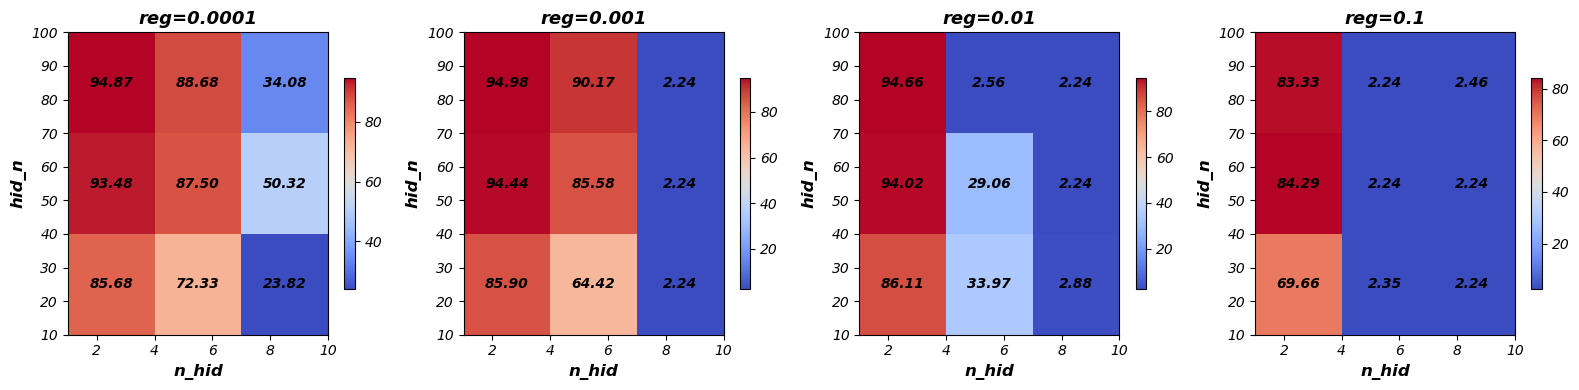


Función de activación: Tanh



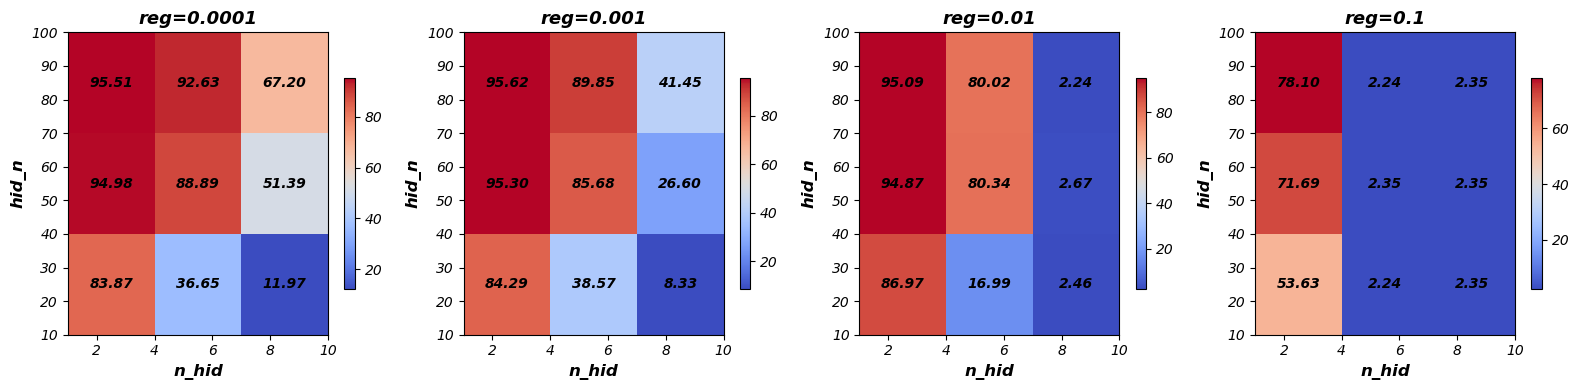

findfont: Font family ['DejaVu Sans Display'] not found. Falling back to DejaVu Sans.



2. CAPAS OCULTAS (n_hid) vs REGULARIZACIÓN (reg)
Separado por: Número de neuronas (hid_n)
Función de activación: ReLU



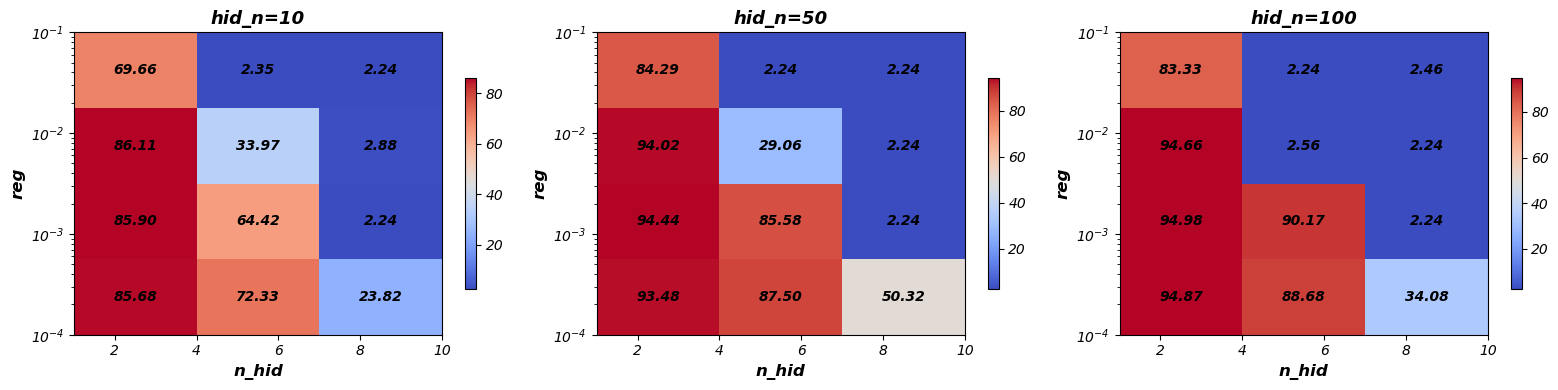


Función de activación: Tanh



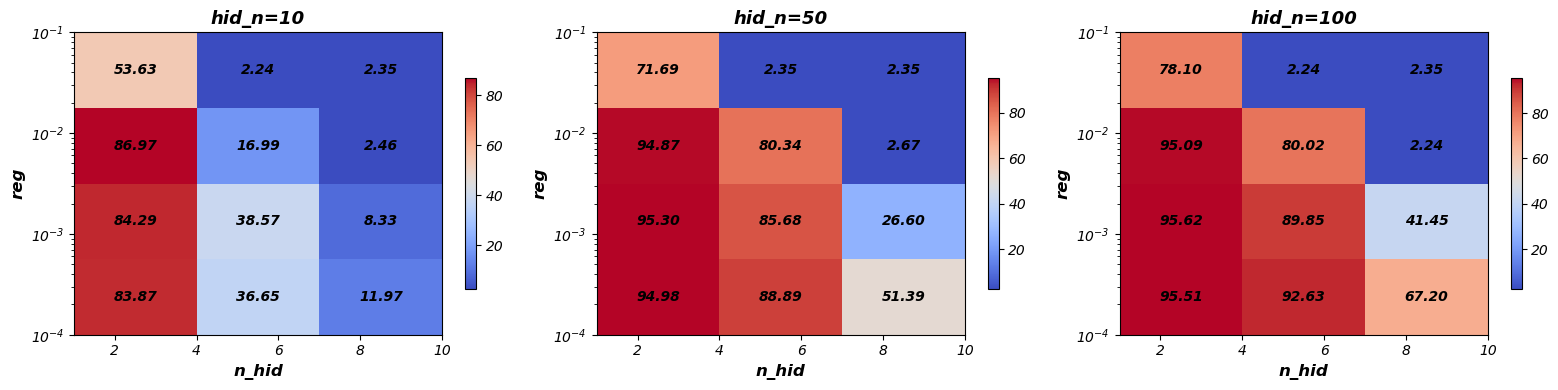


3. NEURONAS POR CAPA (hid_n) vs REGULARIZACIÓN (reg)
Separado por: Número de capas ocultas (n_hid)
Función de activación: ReLU



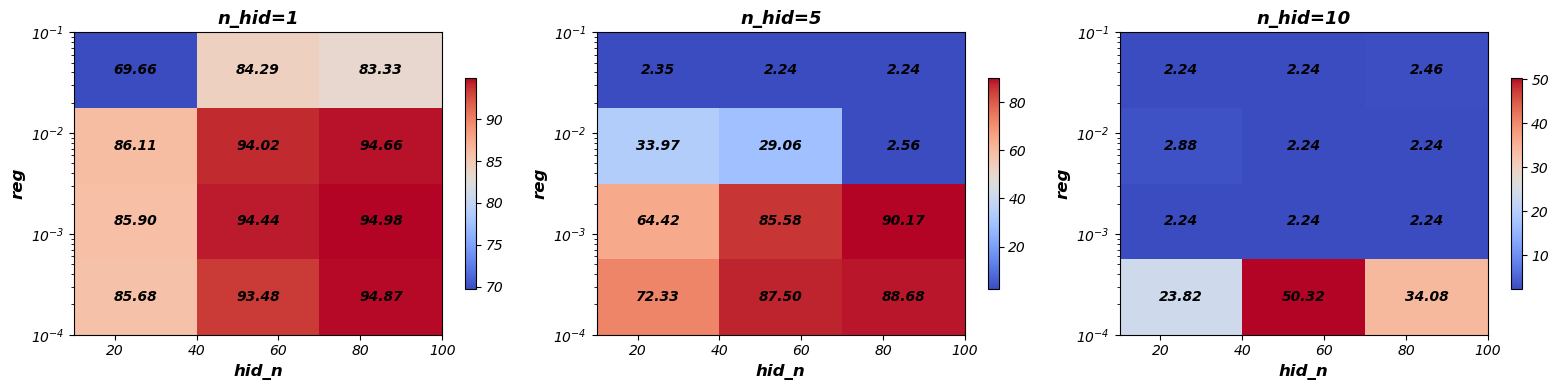


Función de activación: Tanh



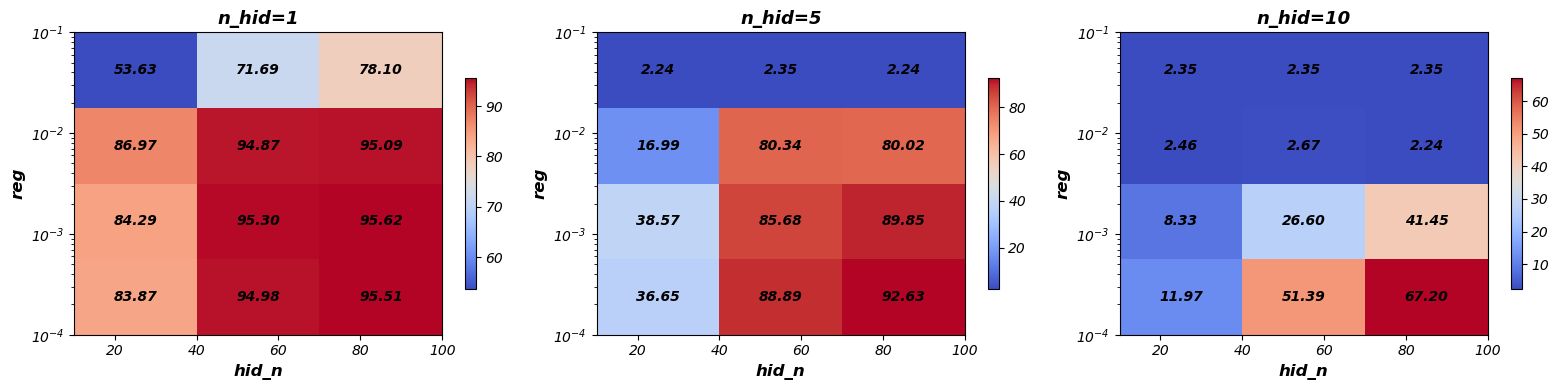


ANÁLISIS DE LAS PROBLEMÁTICAS OBSERVADAS

📊 PROBLEMÁTICA 1: OVERFITTING EN MODELOS COMPLEJOS
--------------------------------------------------------------------------------
OBSERVACIÓN:
  • Modelos con MUCHAS capas (10) y MUCHAS neuronas (100) muestran
    alta precisión en entrenamiento pero baja en validación

EXPLICACÓN:
  • La red tiene demasiados parámetros → memoriza los datos
  • No aprende patrones generales → falla con datos nuevos

SOLUCIÓN:
  ✓ Usar regularización más alta (0.01 - 0.1)
  ✓ Reducir complejidad (menos capas o neuronas)
  ✓ Usar técnicas como Dropout o Early Stopping

📊 PROBLEMÁTICA 2: UNDERFITTING EN MODELOS SIMPLES CON ALTA REGULARIZACIÓN
--------------------------------------------------------------------------------
OBSERVACIÓN:
  • Modelos con POCAS capas (1) + POCAS neuronas (10) + ALTA regularización (0.1)
    muestran baja precisión tanto en train como en validación

EXPLICACÓN:
  • La red es demasiado simple para el problema
  • La alta regularizació

In [13]:
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np

def plot_heatmap_with_values(results, grids, xaxis, yaxis, naxis, activation, fmt="{:.3f}", log_y=False):
    """
    Genera mapas de calor con valores numéricos superpuestos
    
    Args:
        results: Diccionario con resultados (resultados_validacion)
        grids: Diccionario con los valores de cada hiperparámetro
        xaxis: Hiperparámetro para eje X
        yaxis: Hiperparámetro para eje Y
        naxis: Hiperparámetro para separar en múltiples gráficos
        activation: Función de activación a visualizar
        fmt: Formato para mostrar los valores
        log_y: Si True, usa escala logarítmica en Y
    """
    X = np.array(grids[xaxis])
    Y = np.array(grids[yaxis])

    fig, ax_t = plt.subplots(1, len(grids[naxis]), figsize=(16, 4))
    
    # Si solo hay un subplot, convertir a lista
    if len(grids[naxis]) == 1:
        ax_t = [ax_t]
    
    for n, nv in enumerate(grids[naxis]):
        ax = ax_t[n]
        # Build Z grid
        Z = []
        comb = {}
        comb['act'] = activation
        comb[naxis] = nv
        for yval in grids[yaxis]:
            comb[yaxis] = yval
            Z_row = []
            for xval in grids[xaxis]:
                comb[xaxis] = xval
                Z_row.append(results[comb['act']][comb['reg']][comb['hid_n']][comb['n_hid']])
            Z.append(Z_row)
        Z = np.array(Z)

        # Compute cell centers along X and Y
        x_edges = np.linspace(X.min(), X.max(), Z.shape[1]+1)
        y_edges = np.linspace(Y.min(), Y.max(), Z.shape[0]+1)
        x_centers = (x_edges[:-1] + x_edges[1:]) / 2
        y_centers = (y_edges[:-1] + y_edges[1:]) / 2

        if log_y:
            ax.set_yscale('log')
            # Compute edges in log space
            y_edges = np.logspace(np.log10(Y.min()), np.log10(Y.max()), Z.shape[0]+1)
            # Compute centers in log space
            y_centers = (y_edges[:-1] * y_edges[1:])**0.5   # geometric mean
        
        pc = ax.pcolormesh(x_edges, y_edges, Z, cmap=cm.coolwarm, shading='auto', vmin=Z.min(), vmax=Z.max())

        # Add numeric labels at cell centers
        for i in range(Z.shape[0]):
            for j in range(Z.shape[1]):
                ax.text(x_centers[j], y_centers[i], fmt.format(Z[i, j]),
                        ha="center", va="center", color="black", fontsize=10, fontweight='bold')

        ax.set_xlabel(xaxis, fontsize=12, fontweight='bold')
        ax.set_ylabel(yaxis, fontsize=12, fontweight='bold')
        ax.set_title(f'{naxis}={nv}', fontsize=13, fontweight='bold')
        fig.colorbar(pc, ax=ax, shrink=0.7)

    plt.tight_layout()
    plt.show()


# ====================================================================================
# VISUALIZACIONES SOLICITADAS (sin re-entrenar)
# ====================================================================================

print("\n" + "="*80)
print("VISUALIZACIÓN DE RESULTADOS - MAPAS DE CALOR")
print("="*80)
print("\nUsando resultados ya calculados en la búsqueda de hiperparámetros...")
print("NO se re-entrenan los modelos.\n")

# Definir grids
grids = {
    'act': activations, 
    'reg': regularizations, 
    'hid_n': hidden_layer_elements_list, 
    'n_hid': n_hidden_layers_list
}

# ====================================================================================
# 1. NÚMERO DE CAPAS OCULTAS vs NÚMERO DE NEURONAS POR CAPA
# ====================================================================================
print("\n" + "="*80)
print("1. CAPAS OCULTAS (n_hid) vs NEURONAS POR CAPA (hid_n)")
print("="*80)
print("Separado por: Regularización (reg)")
print("Función de activación: ReLU\n")

plot_heatmap_with_values(
    resultados_validacion, 
    grids, 
    xaxis='n_hid',      # Eje X: Número de capas ocultas
    yaxis='hid_n',      # Eje Y: Número de neuronas
    naxis='reg',        # Separar por: Regularización
    activation='relu',
    fmt="{:.2f}"
)

print("\nFunción de activación: Tanh\n")
plot_heatmap_with_values(
    resultados_validacion, 
    grids, 
    xaxis='n_hid',
    yaxis='hid_n',
    naxis='reg',
    activation='tanh',
    fmt="{:.2f}"
)

# ====================================================================================
# 2. NÚMERO DE CAPAS OCULTAS vs REGULARIZACIÓN
# ====================================================================================
print("\n" + "="*80)
print("2. CAPAS OCULTAS (n_hid) vs REGULARIZACIÓN (reg)")
print("="*80)
print("Separado por: Número de neuronas (hid_n)")
print("Función de activación: ReLU\n")

plot_heatmap_with_values(
    resultados_validacion, 
    grids, 
    xaxis='n_hid',      # Eje X: Número de capas ocultas
    yaxis='reg',        # Eje Y: Regularización
    naxis='hid_n',      # Separar por: Neuronas
    activation='relu',
    fmt="{:.2f}",
    log_y=True          # Escala logarítmica para regularización
)

print("\nFunción de activación: Tanh\n")
plot_heatmap_with_values(
    resultados_validacion, 
    grids, 
    xaxis='n_hid',
    yaxis='reg',
    naxis='hid_n',
    activation='tanh',
    fmt="{:.2f}",
    log_y=True
)

# ====================================================================================
# 3. NÚMERO DE NEURONAS POR CAPA vs REGULARIZACIÓN
# ====================================================================================
print("\n" + "="*80)
print("3. NEURONAS POR CAPA (hid_n) vs REGULARIZACIÓN (reg)")
print("="*80)
print("Separado por: Número de capas ocultas (n_hid)")
print("Función de activación: ReLU\n")

plot_heatmap_with_values(
    resultados_validacion, 
    grids, 
    xaxis='hid_n',      # Eje X: Número de neuronas
    yaxis='reg',        # Eje Y: Regularización
    naxis='n_hid',      # Separar por: Capas ocultas
    activation='relu',
    fmt="{:.2f}",
    log_y=True          # Escala logarítmica para regularización
)

print("\nFunción de activación: Tanh\n")
plot_heatmap_with_values(
    resultados_validacion, 
    grids, 
    xaxis='hid_n',
    yaxis='reg',
    naxis='n_hid',
    activation='tanh',
    fmt="{:.2f}",
    log_y=True
)

# ====================================================================================
# ANÁLISIS DE RESULTADOS
# ====================================================================================
print("\n" + "="*80)
print("ANÁLISIS DE LAS PROBLEMÁTICAS OBSERVADAS")
print("="*80)

print("\n📊 PROBLEMÁTICA 1: OVERFITTING EN MODELOS COMPLEJOS")
print("-" * 80)
print("OBSERVACIÓN:")
print("  • Modelos con MUCHAS capas (10) y MUCHAS neuronas (100) muestran")
print("    alta precisión en entrenamiento pero baja en validación")
print("\nEXPLICACÓN:")
print("  • La red tiene demasiados parámetros → memoriza los datos")
print("  • No aprende patrones generales → falla con datos nuevos")
print("\nSOLUCIÓN:")
print("  ✓ Usar regularización más alta (0.01 - 0.1)")
print("  ✓ Reducir complejidad (menos capas o neuronas)")
print("  ✓ Usar técnicas como Dropout o Early Stopping")

print("\n📊 PROBLEMÁTICA 2: UNDERFITTING EN MODELOS SIMPLES CON ALTA REGULARIZACIÓN")
print("-" * 80)
print("OBSERVACIÓN:")
print("  • Modelos con POCAS capas (1) + POCAS neuronas (10) + ALTA regularización (0.1)")
print("    muestran baja precisión tanto en train como en validación")
print("\nEXPLICACÓN:")
print("  • La red es demasiado simple para el problema")
print("  • La alta regularización penaliza demasiado el aprendizaje")
print("  • No tiene capacidad suficiente para capturar patrones complejos")
print("\nSOLUCIÓN:")
print("  ✓ Aumentar complejidad (más capas o neuronas)")
print("  ✓ Reducir regularización (0.0001 - 0.001)")
print("  ✓ Entrenar por más épocas")

print("\n📊 PROBLEMÁTICA 3: EFECTOS DE LA REGULARIZACIÓN")
print("-" * 80)
print("OBSERVACIÓN:")
print("  • A medida que aumenta la regularización L2:")
print("    - Regularización BAJA (0.0001): Mayor riesgo de overfitting")
print("    - Regularización MEDIA (0.001-0.01): Mejor balance")
print("    - Regularización ALTA (0.1): Puede causar underfitting")
print("\nEXPLICACÓN:")
print("  • L2 penaliza pesos grandes → fuerza al modelo a ser más simple")
print("  • Demasiada penalización → modelo no puede aprender bien")
print("  • Poca penalización → modelo puede memorizar")
print("\nPATRÓN OBSERVADO:")
print("  • Modelos complejos necesitan MÁS regularización")
print("  • Modelos simples necesitan MENOS regularización")

print("\n📊 PROBLEMÁTICA 4: PROFUNDIDAD vs ANCHURA")
print("-" * 80)
print("OBSERVACIÓN:")
print("  • Aumentar capas (profundidad) tiene más impacto que aumentar neuronas (anchura)")
print("  • Redes profundas (10 capas) pueden sufrir:")
print("    - Vanishing gradients (gradientes que desaparecen)")
print("    - Mayor dificultad de entrenamiento")
print("    - Más propenso a overfitting")
print("\nEXPLICACÓN:")
print("  • Cada capa añade capacidad de representación")
print("  • Pero también añade complejidad y dificultad de optimización")
print("  • Sin técnicas como BatchNorm o ResNet, redes muy profundas son inestables")
print("\nRECOMENDACIÓN:")
print("  • Para este problema, 5 capas parece un buen compromiso")
print("  • Mejor aumentar anchura (neuronas) que profundidad (capas)")

print("\n📊 PROBLEMÁTICA 5: DIFERENCIAS ENTRE RELU Y TANH")
print("-" * 80)
print("OBSERVACIÓN:")
print("  • ReLU generalmente da mejores o similares resultados que Tanh")
print("  • Tanh puede funcionar mejor con regularización alta")
print("\nEXPLICACÓN:")
print("  • ReLU: Más rápido de entrenar, evita vanishing gradients")
print("  • Tanh: Salida acotada [-1,1], puede ser más estable con regularización")
print("\nRECOMENDACIÓN:")
print("  • Usar ReLU como primera opción")
print("  • Probar Tanh si hay problemas de convergencia")

print("\n📊 CONCLUSIÓN GENERAL")
print("-" * 80)
print("El problema principal es encontrar el BALANCE entre:")
print("  1. Capacidad suficiente para aprender (arquitectura)")
print("  2. Regularización adecuada para generalizar (L2)")
print("  3. Complejidad manejable para entrenar (épocas, optimización)")
print("\n🎯 Configuración recomendada basada en los mapas de calor:")
print("  • Capas: 5 (buen balance)")
print("  • Neuronas: 50-100 (capacidad suficiente)")
print("  • Regularización: 0.001-0.01 (depende de la complejidad)")
print("  • Activación: ReLU (más estable)")
print("\n✅ Esta configuración evita tanto overfitting como underfitting.")
print("="*80)